In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import os
import datetime

sns.set_theme(style="dark")
%matplotlib inline

In [2]:
os.chdir("../")

# Data processing

In [3]:
conn = sqlite3.connect("im.db")
cursor = conn.cursor()

In [4]:
query = """
-- SQLite
with mov as (
    select 
        movies.*,
        cast(strftime('%Y', date(opening_date)) as int) opening_year, 
        cast(strftime('%Y', date(release_date)) as int) release_year 
    from movies
),

new_cpi as (
    select *, (select avg_annual_cpi from cpi where year = 2022) current_cpi
    from cpi
    ),

af_filtered as (
    select distinct a.*
    from actor_filmo a
    left join actor_movie b on a.crew_url = b.actor_url
    left join mov on b.movie_id = mov.movie_id
    where 1=1
    and a.movie_id not in (select movie_id from movies)
    and a.year < mov.release_year
),

af_adj as (
    select 
        af.*,
        revenue_world * avg_annual_cpi / current_cpi revenue_world_adj
    from af_filtered af
    left join new_cpi on af.year = new_cpi.year
    where 1=1
    and is_star = 'True'
),

df_filtered as (
    select distinct a.*
    from director_filmo a
    left join director_movie b on a.crew_url = b.director_url
    left join mov on b.movie_id = mov.movie_id
    where 1=1
    and a.movie_id not in (select movie_id from movies)
    and a.year < mov.release_year
),

df_adj as (
    select 
        df.*,
        revenue_world * avg_annual_cpi / current_cpi revenue_world_adj
    from df_filtered df
    left join new_cpi on df.year = new_cpi.year
    where 1=1
),

wf_filtered as (
    select distinct a.*
    from writer_filmo a
    left join writer_movie b on a.crew_url = b.writer_url
    left join mov on b.movie_id = mov.movie_id
    where 1=1
    and a.movie_id not in (select movie_id from movies)
    and a.year < mov.release_year
),

wf_adj as (
    select 
        wf.*,
        revenue_world * avg_annual_cpi / current_cpi revenue_world_adj
    from wf_filtered wf
    left join new_cpi on wf.year = new_cpi.year
    where movie_id not in (select movie_id from movies)
),

actor_profile as (
    select 
        af.crew_url actor_id, 
        a.name,
        -- avg(rating) avg_actor_movie_rating,
        -- avg(rating_count) avg_actor_movie_rating_count,
        -- avg(revenue_world_adj) avg_actor_movie_revenue_world_adj,

        -- avg(case when is_star = 'True' then rating end) avg_star_actor_movie_rating,
        -- avg(case when is_star = 'True' then rating_count end) avg_star_actor_movie_rating_count,
        -- avg(case when is_star = 'True' then revenue_world_adj end) avg_star_actor_movie_revenue_world_adj,

        -- max(case when is_star = 'True' then rating end) max_star_actor_movie_rating,
        -- max(case when is_star = 'True' then rating_count end) max_star_actor_movie_rating_count,
        -- max(case when is_star = 'True' then revenue_world_adj end) max_star_actor_movie_revenue_world_adj,

        -- min(case when is_star = 'True' then rating end) min_star_actor_movie_rating,
        -- min(case when is_star = 'True' then rating_count end) min_star_actor_movie_rating_count,
        -- min(case when is_star = 'True' then revenue_world_adj end) min_star_actor_movie_revenue_world_adj,

        -- avg(case when is_star = 'False' then rating end) avg_non_star_actor_movie_rating,
        -- avg(case when is_star = 'False' then rating_count end) avg_non_star_actor_movie_rating_count,
        -- avg(case when is_star = 'False' then revenue_world_adj end) avg_non_star_actor_movie_revenue_world_adj,

        sum(rating) sum_star_actor_movie_rating,
        sum(rating_count) sum_star_actor_movie_rating_count,
        sum(revenue_world_adj) sum_star_actor_movie_revenue_world_adj,

        count(crew_url) cnt_star_actor_movie

    from af_adj af
    left join actors a on af.crew_url = a.actor_id
    group by 
        af.crew_url, 
        a.name
),

director_profile as (
    select 
        df.crew_url director_id, 
        d.name,
        avg(rating) avg_director_movie_rating,
        avg(rating_count) avg_director_movie_rating_count,
        avg(revenue_world_adj) avg_director_movie_revenue_world_adj,

        max(rating) max_director_movie_rating,
        max(rating_count) max_director_movie_rating_count,
        max(revenue_world_adj) max_director_movie_revenue_world_adj,

        min(rating) min_director_movie_rating,
        min(rating_count) min_director_movie_rating_count,
        min(revenue_world_adj) min_director_movie_revenue_world_adj,

        sum(rating) sum_director_movie_rating,
        sum(rating_count) sum_director_movie_rating_count,
        sum(revenue_world_adj) sum_director_movie_revenue_world_adj,

        count(crew_url) cnt_director_movie
    from df_adj df
    left join directors d on df.crew_url = d.director_id
    group by 
        df.crew_url, 
        d.name
),

writer_profile as (
    select 
        wf.crew_url writer_id, 
        w.name,
        avg(rating) avg_writer_movie_rating,
        avg(rating_count) avg_writer_movie_rating_count,
        avg(revenue_world_adj) avg_writer_movie_revenue_world_adj,

        max(rating) max_writer_movie_rating,
        max(rating_count) max_writer_movie_rating_count,
        max(revenue_world_adj) max_writer_movie_revenue_world_adj,

        min(rating) min_writer_movie_rating,
        min(rating_count) min_writer_movie_rating_count,
        min(revenue_world_adj) min_writer_movie_revenue_world_adj,

        sum(rating) sum_writer_movie_rating,
        sum(rating_count) sum_writer_movie_rating_count,
        sum(revenue_world_adj) sum_writer_movie_revenue_world_adj,

        count(crew_url) cnt_writer_movie 
    from wf_adj wf
    left join writers w on wf.crew_url = w.writer_id
    group by 
        wf.crew_url, 
        w.name
),

movie_af as (
    select 
        am.movie_id,
        sum(sum_star_actor_movie_rating) / sum(cnt_star_actor_movie) avg_movie_rating_by_star_actor,
        sum(sum_star_actor_movie_rating_count) / sum(cnt_star_actor_movie) avg_movie_rating_count_by_star_actor,
        sum(sum_star_actor_movie_revenue_world_adj) / sum(cnt_star_actor_movie) avg_movie_revenue_world_adj_by_star_actor
    from actor_movie am
    left join actor_profile ap on am.actor_url = ap.actor_id
    where is_star = 'True'
    group by am.movie_id
),

movie_df as (
    select 
        dm.movie_id,
        sum(sum_director_movie_rating) / sum(cnt_director_movie) avg_movie_rating_by_director,
        sum(sum_director_movie_rating_count) / sum(cnt_director_movie) avg_movie_rating_count_by_director,
        sum(sum_director_movie_revenue_world_adj) / sum(cnt_director_movie) avg_movie_revenue_world_adj_by_director
    from director_movie dm
    left join director_profile dp on dm.director_url = dp.director_id
    group by dm.movie_id
),

movie_wf as (
    select 
        wm.movie_id,
        sum(sum_writer_movie_rating) / sum(cnt_writer_movie) avg_movie_rating_by_writer,
        sum(sum_writer_movie_rating_count) / sum(cnt_writer_movie) avg_movie_rating_count_by_writer,
        sum(sum_writer_movie_revenue_world_adj) / sum(cnt_writer_movie) avg_movie_revenue_world_adj_by_writer
    from writer_movie wm
    left join writer_profile wp on wm.writer_url = wp.writer_id
    group by wm.movie_id
),

total_rating as (
select 
    movie_id,
    sum(vote_count) rating_count
    from rating_dist
    group by movie_id
),

mov_adj as (
    select 
        mov.movie_rank,
        mov.movie_id,
        mov.name,
        mov.popularity,
        mov.rating,
        tr.rating_count,
        -- mov.user_review_count,
        mov.critic_review_count,
        mov.runtime,
        mov.release_date,
        mov.release_year,

        ma.avg_movie_rating_by_star_actor,
        ma.avg_movie_rating_count_by_star_actor,
        ma.avg_movie_revenue_world_adj_by_star_actor / 10E6 avg_movie_revenue_world_adj_by_star_actor,

        md.avg_movie_rating_by_director,
        md.avg_movie_rating_count_by_director,
        md.avg_movie_revenue_world_adj_by_director / 10E6 avg_movie_revenue_world_adj_by_director,

        mw.avg_movie_rating_by_writer,
        mw.avg_movie_rating_count_by_writer,
        mw.avg_movie_revenue_world_adj_by_writer / 10E6 avg_movie_revenue_world_adj_by_writer,

        revenue_world * avg_annual_cpi / current_cpi / 10E6 revenue_world_adj,
        revenue_usa * avg_annual_cpi / current_cpi / 10E6 revenue_usa_adj,
        budget * avg_annual_cpi / current_cpi / 10E6 budget_adj

    from mov
    left join new_cpi on mov.release_year = new_cpi.year
    left join movie_af ma on mov.movie_id = ma.movie_id
    left join movie_df md on mov.movie_id = md.movie_id
    left join movie_wf mw on mov.movie_id = mw.movie_id
    left join total_rating tr on mov.movie_id =tr.movie_id
)

select * from mov_adj
"""
movies = pd.read_sql(query, conn)
movies['release_date'] = pd.to_datetime(movies['release_date'], format="%Y-%m-%d")

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 22 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   movie_rank                                 250 non-null    int64         
 1   movie_id                                   250 non-null    object        
 2   name                                       207 non-null    object        
 3   popularity                                 228 non-null    float64       
 4   rating                                     250 non-null    float64       
 5   rating_count                               250 non-null    int64         
 6   critic_review_count                        250 non-null    int64         
 7   runtime                                    244 non-null    float64       
 8   release_date                               250 non-null    datetime64[ns]
 9   release_year         

# Analysis

## Correlation matrix

In [6]:
movies['roi_world'] = (movies['revenue_world_adj'] - movies['budget_adj'])/movies['budget_adj']
movies['roi_usa'] = (movies['revenue_usa_adj'] - movies['budget_adj'])/movies['budget_adj']

movies['days_since_release'] = (pd.to_datetime(datetime.date.today()) - movies['release_date']).dt.days

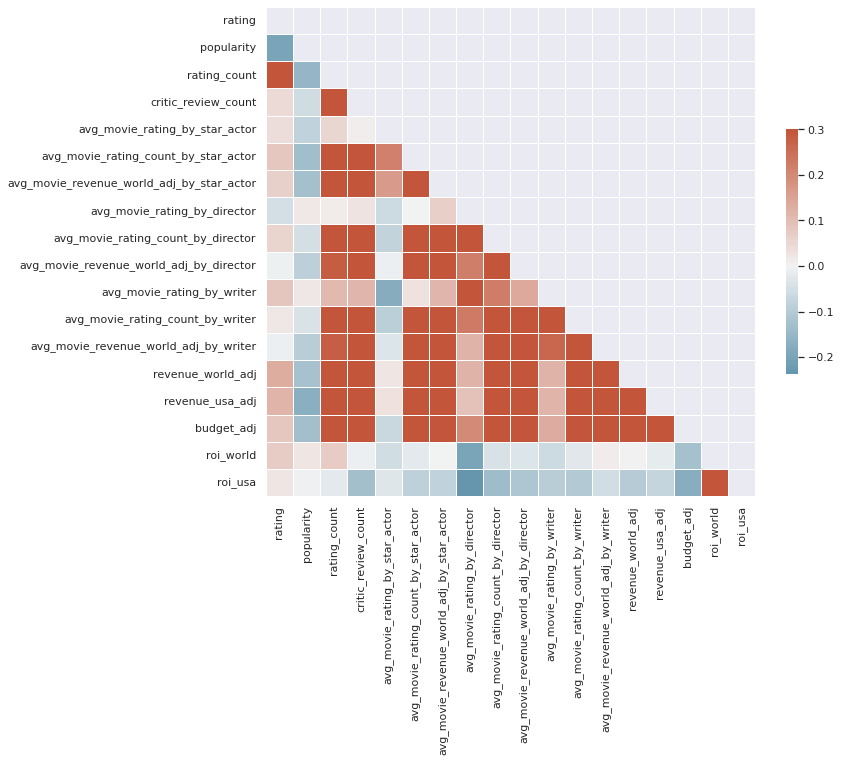

In [7]:
numerical_cols = [
    'rating', 'popularity', 'rating_count', 
    # 'days_since_release',
    'critic_review_count',
    'avg_movie_rating_by_star_actor',
    'avg_movie_rating_count_by_star_actor',
    'avg_movie_revenue_world_adj_by_star_actor',
    'avg_movie_rating_by_director',
    'avg_movie_rating_count_by_director',
    'avg_movie_revenue_world_adj_by_director',
    'avg_movie_rating_by_writer',
    'avg_movie_rating_count_by_writer',
    'avg_movie_revenue_world_adj_by_writer',
    'revenue_world_adj',
    'revenue_usa_adj',
    'budget_adj',
    'roi_world',
    'roi_usa'
    ]

def corr_matrix(df, num_cols):

    corr = df[num_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr_matrix(movies, numerical_cols)

In [8]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import r2_score

In [9]:
def linear_regression(df, x_cols, y_col):
    new_data = df[x_cols + [y_col]].dropna()

    X = [list(row.values) for _, row in new_data[x_cols].iterrows()]
    X_OLS = sm.add_constant(X)
    y = new_data[y_col].values


    model = sm.OLS(y, X_OLS)
    model.data.xnames = ['const'] + x_cols
    results = model.fit()
    
    return results

## Commercial Success

### Revenue worldwide

In [10]:
x_cols = [
    # 'rating',
    # 'popularity', 
    # 'rating_count', 
    # 'revenue_world_adj',
    # 'revenue_usa_adj',
    # 'roi_usa',
    # 'roi_world',
    'critic_review_count',
    'avg_movie_rating_by_star_actor',
    'avg_movie_rating_count_by_star_actor',
    'avg_movie_revenue_world_adj_by_star_actor',
    'avg_movie_rating_by_director',
    'avg_movie_rating_count_by_director',
    'avg_movie_revenue_world_adj_by_director',
    'avg_movie_rating_by_writer',
    'avg_movie_rating_count_by_writer',
    'avg_movie_revenue_world_adj_by_writer',
    'budget_adj',
    ]

y_col = 'revenue_world_adj'

res = linear_regression(movies, x_cols, y_col)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     69.14
Date:                Wed, 11 May 2022   Prob (F-statistic):           7.87e-49
Time:                        07:40:58   Log-Likelihood:                -571.26
No. Observations:                 142   AIC:                             1167.
Df Residuals:                     130   BIC:                             1202.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -3.1852     34.147     -0.093      0.926     -70.741      64.370
critic_review_count                           0.0049      0.010      0.481      0.631      -0.015       0.025
avg_movie_rating_by_star_actor                8.2627      4.687      1.763      0.080      -1.010      17.535
avg_movie_rating_count_by_star_actor         -0.0002   5.91e-05     -2.845      0.005      -0.000   -5.12e-05
avg_movie_revenue_world_adj_by_star_actor     6.7974      2.156      3.152      0.002       2.531      11.063
avg_movie_rating_by_director                 -7.2592      2.914     -2.491      0.014     -13.025      -1.494
avg_movie_rating_count_by_director         4.476e-05   2.64e-05      1.696      0.092   -7.47e-06     9.7e-05
avg_movie_revenue_world_adj_by_director       0.0195      1.008      0.019      0.985      -1.975       2.015
avg_movie_rating_by_writer                   -0.3324      2.376     -0.140      0.889      -5.034       4.369
avg_movie_rating_count_by_writer          -5.829e-05   3.47e-05     -1.679      0.096      -0.000    1.04e-05
avg_movie_revenue_world_adj_by_writer         1.9586      1.144      1.712      0.089      -0.305       4.222
budget_adj                                    5.1917      0.413     12.569      0.000       4.375       6.009
==============================================================================
Omnibus:                       39.147   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.239
Skew:                           0.882   Prob(JB):                     4.84e-37
Kurtosis:                       8.015   Cond. No.                     6.59e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

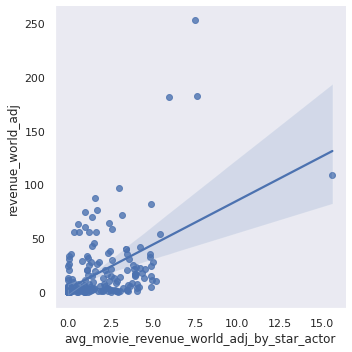

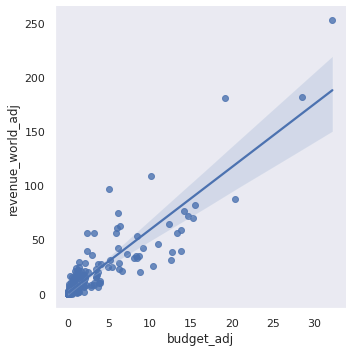

In [11]:
sns.lmplot(x='avg_movie_revenue_world_adj_by_star_actor', y=y_col, data=movies, 
scatter=True, fit_reg=True)

sns.lmplot(x='budget_adj', y=y_col, data=movies, 
scatter=True, fit_reg=True)

### Return on Investment

In [12]:
x_cols = [
    # 'rating',
    # 'popularity', 
    # 'rating_count', 
    # 'revenue_world_adj',
    # 'revenue_usa_adj',
    # 'roi_usa',
    # 'roi_world',
    'critic_review_count',
    'avg_movie_rating_by_star_actor',
    'avg_movie_rating_count_by_star_actor',
    'avg_movie_revenue_world_adj_by_star_actor',
    'avg_movie_rating_by_director',
    'avg_movie_rating_count_by_director',
    'avg_movie_revenue_world_adj_by_director',
    'avg_movie_rating_by_writer',
    'avg_movie_rating_count_by_writer',
    'avg_movie_revenue_world_adj_by_writer',
    'budget_adj',
    ]

y_col = 'roi_world'

res = linear_regression(movies, x_cols, y_col)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     2.218
Date:                Wed, 11 May 2022   Prob (F-statistic):             0.0170
Time:                        07:41:00   Log-Likelihood:                -579.47
No. Observations:                 142   AIC:                             1183.
Df Residuals:                     130   BIC:                             1218.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                       113.0149     36.179      3.124      0.002      41.438     184.592
critic_review_count                          -0.0014      0.011     -0.130      0.897      -0.023       0.020
avg_movie_rating_by_star_actor               -3.7163      4.966     -0.748      0.456     -13.541       6.108
avg_movie_rating_count_by_star_actor      -7.932e-05   6.26e-05     -1.266      0.208      -0.000    4.46e-05
avg_movie_revenue_world_adj_by_star_actor     3.3996      2.285      1.488      0.139      -1.120       7.919
avg_movie_rating_by_director                -10.3829      3.088     -3.363      0.001     -16.492      -4.274
avg_movie_rating_count_by_director         3.995e-05    2.8e-05      1.428      0.156   -1.54e-05    9.53e-05
avg_movie_revenue_world_adj_by_director      -1.6381      1.068     -1.533      0.128      -3.752       0.476
avg_movie_rating_by_writer                   -1.3312      2.518     -0.529      0.598      -6.313       3.650
avg_movie_rating_count_by_writer          -2.768e-05   3.68e-05     -0.752      0.453      -0.000    4.51e-05
avg_movie_revenue_world_adj_by_writer         1.6782      1.212      1.384      0.169      -0.720       4.077
budget_adj                                   -0.4630      0.438     -1.058      0.292      -1.329       0.403
==============================================================================
Omnibus:                      153.980   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3266.802
Skew:                           4.006   Prob(JB):                         0.00
Kurtosis:                      25.089   Cond. No.                     6.59e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Popularity

Popularity can be determined with 2 metrics:

- `popularity` ranking on IMDB. This is the current popularity of the movie.
- `voting_count`, i.e. the number of votes that make up the rating. This can be understood as the popularity overtime of a title.

### Popularity overtime

In [13]:
x_cols = [
    'avg_movie_rating_by_star_actor',
    'avg_movie_rating_count_by_star_actor',
    'avg_movie_revenue_world_adj_by_star_actor',
    'avg_movie_rating_by_director',
    'avg_movie_rating_count_by_director',
    'avg_movie_revenue_world_adj_by_director',
    'avg_movie_rating_by_writer',
    'avg_movie_rating_count_by_writer',
    'avg_movie_revenue_world_adj_by_writer',
    'budget_adj',
    'critic_review_count',
    'revenue_world_adj',
    'revenue_usa_adj',
    # 'rating',
    # 'popularity', 
    # 'rating_count', 
    # 'roi_usa',
    # 'roi_world',
    ]

y_col = 'rating_count'

res = linear_regression(movies, x_cols, y_col)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     7.885
Date:                Wed, 11 May 2022   Prob (F-statistic):           4.02e-11
Time:                        07:41:00   Log-Likelihood:                -1876.8
No. Observations:                 132   AIC:                             3782.
Df Residuals:                     118   BIC:                             3822.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      2.143e+06   9.94e+05      2.156      0.033    1.75e+05    4.11e+06
avg_movie_rating_by_star_actor            -1.497e+05   1.34e+05     -1.114      0.268   -4.16e+05    1.16e+05
avg_movie_rating_count_by_star_actor          2.1956      1.671      1.314      0.191      -1.114       5.505
avg_movie_revenue_world_adj_by_star_actor -1.035e+04   6.13e+04     -0.169      0.866   -1.32e+05    1.11e+05
avg_movie_rating_by_director              -1.497e+05   8.23e+04     -1.818      0.072   -3.13e+05    1.33e+04
avg_movie_rating_count_by_director            2.4466      0.728      3.361      0.001       1.005       3.888
avg_movie_revenue_world_adj_by_director   -1.117e+05   2.74e+04     -4.074      0.000   -1.66e+05   -5.74e+04
avg_movie_rating_by_writer                  3.38e+04   6.75e+04      0.501      0.617   -9.99e+04    1.67e+05
avg_movie_rating_count_by_writer              0.5118      0.957      0.535      0.594      -1.383       2.407
avg_movie_revenue_world_adj_by_writer     -1.188e+04    3.2e+04     -0.371      0.711   -7.52e+04    5.15e+04
budget_adj                                 9945.1514   1.68e+04      0.591      0.556   -2.34e+04    4.33e+04
critic_review_count                          44.5276    282.783      0.157      0.875    -515.459     604.514
revenue_world_adj                         -9043.6084   4819.111     -1.877      0.063   -1.86e+04     499.544
revenue_usa_adj                            4.241e+04   1.34e+04      3.173      0.002    1.59e+04    6.89e+04
==============================================================================
Omnibus:                        5.870   Durbin-Watson:                   1.105
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                5.411
Skew:                           0.422   Prob(JB):                       0.0668
Kurtosis:                       3.520   Cond. No.                     7.07e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

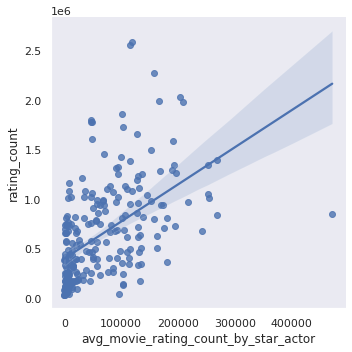

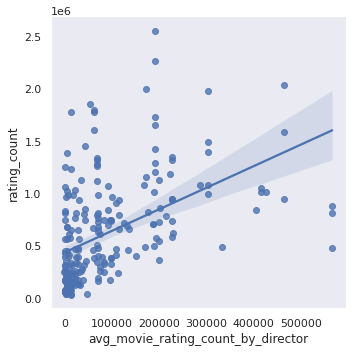

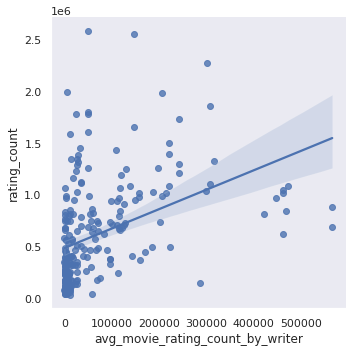

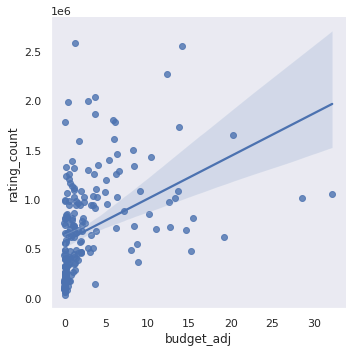

In [14]:
sns.lmplot(x='avg_movie_rating_count_by_star_actor', y=y_col, data=movies, 
scatter=True, fit_reg=True)

sns.lmplot(x='avg_movie_rating_count_by_director', y=y_col, data=movies, 
scatter=True, fit_reg=True)

sns.lmplot(x='avg_movie_rating_count_by_writer', y=y_col, data=movies, 
scatter=True, fit_reg=True)

sns.lmplot(x='budget_adj', y=y_col, data=movies, 
scatter=True, fit_reg=True)

### Current Popularity

In [15]:
x_cols = [
    'avg_movie_rating_by_star_actor',
    'avg_movie_rating_count_by_star_actor',
    'avg_movie_revenue_world_adj_by_star_actor',
    'avg_movie_rating_by_director',
    'avg_movie_rating_count_by_director',
    'avg_movie_revenue_world_adj_by_director',
    'avg_movie_rating_by_writer',
    'avg_movie_rating_count_by_writer',
    'avg_movie_revenue_world_adj_by_writer',
    'budget_adj',
    'critic_review_count',
    'revenue_world_adj',
    'revenue_usa_adj',
    'days_since_release',
    'rating',
    # 'popularity', 
    'rating_count', 
    # 'roi_usa',
    # 'roi_world',
    ]

y_col = 'popularity'

res = linear_regression(movies, x_cols, y_col)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1.549
Date:                Wed, 11 May 2022   Prob (F-statistic):             0.0948
Time:                        07:41:01   Log-Likelihood:                -1207.4
No. Observations:                 131   AIC:                             2449.
Df Residuals:                     114   BIC:                             2498.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      2.602e+04   1.37e+04      1.899      0.060   -1124.454    5.32e+04
avg_movie_rating_by_star_actor             -745.3913   1024.630     -0.727      0.468   -2775.176    1284.393
avg_movie_rating_count_by_star_actor         -0.0071      0.012     -0.572      0.569      -0.032       0.018
avg_movie_revenue_world_adj_by_star_actor   146.8500    429.881      0.342      0.733    -704.742     998.442
avg_movie_rating_by_director                285.1306    587.113      0.486      0.628    -877.936    1448.198
avg_movie_rating_count_by_director            0.0006      0.005      0.117      0.907      -0.010       0.011
avg_movie_revenue_world_adj_by_director       0.3713    202.271      0.002      0.999    -400.326     401.069
avg_movie_rating_by_writer                 -674.1673    525.610     -1.283      0.202   -1715.396     367.061
avg_movie_rating_count_by_writer              0.0038      0.007      0.545      0.587      -0.010       0.018
avg_movie_revenue_world_adj_by_writer      -197.5639    225.258     -0.877      0.382    -643.798     248.670
budget_adj                                  -44.3858    115.679     -0.384      0.702    -273.545     184.773
critic_review_count                          -1.4474      2.176     -0.665      0.507      -5.758       2.863
revenue_world_adj                            28.4949     34.165      0.834      0.406     -39.186      96.175
revenue_usa_adj                             -76.1972     96.980     -0.786      0.434    -268.314     115.920
days_since_release                           -0.0390      0.048     -0.818      0.415      -0.134       0.056
rating                                    -1572.7200   1660.585     -0.947      0.346   -4862.327    1716.887
rating_count                                 -0.0007      0.001     -0.631      0.529      -0.003       0.001
==============================================================================
Omnibus:                        6.750   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.052
Skew:                           0.452   Prob(JB):                       0.0485
Kurtosis:                       2.460   Cond. No.                     5.82e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.82e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Genres

In [16]:
mg_query = """
with mov as (
    select 
        movies.*,
        cast(strftime('%Y', date(opening_date)) as int) opening_year, 
        cast(strftime('%Y', date(release_date)) as int) release_year 
    from movies
),

mov_adj as (
    select 
        mov.*,
        revenue_world * avg_annual_cpi / current_cpi revenue_world_adj,
        revenue_usa * avg_annual_cpi / current_cpi revenue_usa_adj,
        revenue_usa_opening * avg_annual_cpi / current_cpi revenue_usa_opening_adj,
        budget * avg_annual_cpi / current_cpi budget_adj
    from mov
    left join new_cpi on mov.release_year = new_cpi.year
),

base as (select distinct 
    gm.genre, 
    m.* 
from genre_movie gm
inner join mov_adj m
on gm.movie_id = m.movie_id
),



new_cpi as (
    select *, (select avg_annual_cpi from cpi where year = 2022) current_cpi
    from cpi
    ),


total_rating as (
select 
    movie_id,
    sum(vote_count) rating_count
    from rating_dist
    group by movie_id
)

select 
    genre,
    movie_rank,
    base.movie_id,
    name,
    popularity,
    rating,
    tr.rating_count,
    critic_review_count,
    budget_adj / 10E6 budget_adj,
    revenue_usa_adj / 10E6 revenue_usa_adj,
    revenue_usa_opening_adj / 10E6 revenue_usa_opening_adj,
    revenue_world_adj / 10E6 revenue_world_adj,
    runtime,
    opening_date,
    release_date
from base
left join total_rating tr
on base.movie_id =tr.movie_id
"""
movie_genre = pd.read_sql(mg_query, conn)

In [17]:
movie_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   genre                    729 non-null    object 
 1   movie_rank               729 non-null    int64  
 2   movie_id                 729 non-null    object 
 3   name                     600 non-null    object 
 4   popularity               674 non-null    float64
 5   rating                   729 non-null    float64
 6   rating_count             729 non-null    int64  
 7   critic_review_count      729 non-null    int64  
 8   budget_adj               617 non-null    float64
 9   revenue_usa_adj          643 non-null    float64
 10  revenue_usa_opening_adj  594 non-null    float64
 11  revenue_world_adj        707 non-null    float64
 12  runtime                  710 non-null    float64
 13  opening_date             594 non-null    object 
 14  release_date             7

In [18]:
movie_genre['roi_world'] = (movie_genre['revenue_world_adj'] - movie_genre['budget_adj'])/movie_genre['budget_adj']
movie_genre['roi_usa'] = (movie_genre['revenue_usa_adj'] - movie_genre['budget_adj'])/movie_genre['budget_adj']

movie_genre['release_date'] = pd.to_datetime(movie_genre['release_date'], format="%Y-%m-%d")
movie_genre['days_since_release'] = (pd.to_datetime(datetime.date.today()) - movie_genre['release_date']).dt.days

In [19]:
genre_summary = movie_genre.groupby('genre').agg({
    'rating':['count','mean', 'median', 'max', 'min' ,'std'],
    'rating_count':['count','mean', 'median', 'max', 'min' ,'std'],
    'critic_review_count':['count','mean', 'median', 'max', 'min' ,'std'],
    'revenue_usa_adj':['count','mean', 'median', 'max', 'min' ,'std'],
    'revenue_usa_opening_adj':['count','mean', 'median', 'max', 'min' ,'std'],
    'revenue_world_adj':['count','mean', 'median', 'max', 'min' ,'std'],
    'roi_world':['count','mean', 'median', 'max', 'min' ,'std'],
    'roi_usa':['count','mean', 'median', 'max', 'min' ,'std']
})

In [20]:
genre_summary['rating']

,count,mean,median,max,min,std
genre,,,,,,
Action,48,8.370833,8.30,9.0,8.0,0.260080
Adventure,60,8.315000,8.25,9.0,8.0,0.239225
Animation,23,8.247826,8.20,8.6,8.0,0.178044
Biography,29,8.251724,8.20,9.0,8.1,0.211492
Comedy,49,8.253061,8.20,8.8,8.0,0.167210
Crime,51,8.350980,8.30,9.2,8.1,0.276675
Drama,181,8.317127,8.30,9.3,8.0,0.237778
Family,27,8.229630,8.20,8.6,8.0,0.170553
Fantasy,32,8.343750,8.30,9.0,8.0,0.277009


In [21]:
genre_summary['rating_count']

,count,mean,median,max,min,std
genre,,,,,,
Action,48,885113.250000,794858.5,2553989,35745,582379.930693
Adventure,60,752262.283333,714357.0,2267580,28215,495517.379020
Animation,23,611903.652174,687100.0,1082998,141720,298397.405377
Biography,29,518746.034483,393269.0,1339753,28215,369797.988957
Comedy,49,501369.591837,476243.0,1339753,35745,336277.994121
Crime,51,774990.725490,763159.0,2553989,33862,563984.594955
Drama,181,591119.541436,403845.0,2583883,28215,527989.348074
Family,27,548538.222222,476243.0,1082998,73464,320942.754359
Fantasy,32,752173.875000,671476.5,1797269,35745,446690.486925


In [22]:
genre_summary['critic_review_count']

,count,mean,median,max,min,std
genre,,,,,,
Action,48,290.083333,241.0,835,64,165.727902
Adventure,60,267.783333,220.5,835,54,164.544167
Animation,23,255.652174,227.0,593,116,125.052574
Biography,29,216.172414,156.0,512,54,141.870935
Comedy,49,231.285714,164.0,601,57,149.243090
Crime,51,242.862745,182.0,695,63,150.794565
Drama,181,231.441989,178.0,695,7,145.029281
Family,27,222.185185,194.0,593,7,138.382424
Fantasy,32,259.156250,212.0,593,115,123.769585


In [23]:
genre_summary['revenue_world_adj']

,count,mean,median,max,min,std
genre,,,,,,
Action,46,36.881289,22.968594,253.229378,1.627664e-04,51.420290
Adventure,58,36.704776,21.794816,253.229378,1.038006e-05,48.281356
Animation,22,35.541579,34.869840,82.377134,2.165357e-02,23.862929
Biography,28,10.625234,6.906823,33.975043,1.324555e-04,10.717244
Comedy,45,17.415492,5.094559,82.377134,1.667764e-04,22.548948
Crime,50,11.025812,2.581570,97.258658,7.923323e-07,21.090855
Drama,177,11.749915,2.029055,253.229378,7.923323e-07,25.570093
Family,26,28.828322,23.672455,82.377134,2.659345e-04,26.154791
Fantasy,32,35.323171,21.794816,181.580925,2.874660e-03,38.738520


In [24]:
genre_summary['roi_world']

,count,mean,median,max,min,std
genre,,,,,,
Action,37,8.001193,4.438391,69.490728,-0.637888,11.954854
Adventure,54,9.750093,5.700610,69.490728,-0.996380,13.345872
Animation,19,7.629055,4.334854,22.635818,-0.860281,6.505476
Biography,24,4.197722,2.604519,18.442479,-0.996380,4.680864
Comedy,37,6.449569,4.040937,27.363636,-0.970839,7.005041
Crime,41,5.960837,2.890261,40.723636,-0.999979,8.948122
Drama,146,7.383795,3.226735,121.135835,-0.999979,14.916078
Family,24,7.446246,4.261685,22.635818,-0.832160,6.483714
Fantasy,28,10.257483,7.747780,69.490728,0.926207,13.197326


In [25]:
genre_summary_flat = genre_summary.copy(deep=True)

In [26]:
genre_summary_flat.columns = genre_summary_flat.columns.map('_'.join)

In [27]:
genre_summary_flat.reset_index(inplace=True)

In [28]:
genre_summary_flat

,genre,rating_count,rating_mean,rating_median,rating_max,rating_min,rating_std,rating_count_count,rating_count_mean,rating_count_median,...,roi_world_median,roi_world_max,roi_world_min,roi_world_std,roi_usa_count,roi_usa_mean,roi_usa_median,roi_usa_max,roi_usa_min,roi_usa_std
0,Action,48,8.370833,8.30,9.0,8.0,0.260080,48,885113.250000,794858.5,...,4.438391,69.490728,-0.637888,11.954854,37,3.351164,1.332753,40.908955,-0.764173,7.194877
1,Adventure,60,8.315000,8.25,9.0,8.0,0.239225,60,752262.283333,714357.0,...,5.700610,69.490728,-0.996380,13.345872,50,4.951126,2.036005,40.908955,-0.978482,8.150259
2,Animation,23,8.247826,8.20,8.6,8.0,0.178044,23,611903.652174,687100.0,...,4.334854,22.635818,-0.860281,6.505476,19,2.027658,1.039553,8.395195,-0.860281,2.987448
3,Biography,29,8.251724,8.20,9.0,8.1,0.211492,29,518746.034483,393269.0,...,2.604519,18.442479,-0.996380,4.680864,22,2.029636,1.091658,18.425310,-0.290852,3.847800
4,Comedy,49,8.253061,8.20,8.8,8.0,0.167210,49,501369.591837,476243.0,...,4.040937,27.363636,-0.970839,7.005041,33,2.876256,1.372053,27.363636,-0.987213,5.079211
5,Crime,51,8.350980,8.30,9.2,8.1,0.276675,51,774990.725490,763159.0,...,2.890261,40.723636,-0.999979,8.948122,37,3.547012,1.280023,27.363636,-0.994515,6.640125
6,Drama,181,8.317127,8.30,9.3,8.0,0.237778,181,591119.541436,403845.0,...,3.226735,121.135835,-0.999979,14.916078,131,4.301569,1.360024,121.119945,-0.994515,12.372763
7,Family,27,8.229630,8.20,8.6,8.0,0.170553,27,548538.222222,476243.0,...,4.261685,22.635818,-0.832160,6.483714,22,3.131666,1.094408,18.425310,-0.986164,4.589925
8,Fantasy,32,8.343750,8.30,9.0,8.0,0.277009,32,752173.875000,671476.5,...,7.747780,69.490728,0.926207,13.197326,27,4.341716,1.527324,40.908955,-0.986164,8.184877
9,Film-Noir,4,8.225000,8.20,8.4,8.1,0.150000,4,169019.750000,161771.5,...,-0.943886,-0.828725,-0.984697,0.080885,1,-0.828970,-0.828970,-0.828970,-0.828970,NaN


In [29]:
from sklearn.cluster import KMeans

In [30]:
X = genre_summary_flat[["revenue_world_adj_mean","rating_count_mean"]]

kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X)

identified_clusters = kmeans.fit_predict(X)

# genre_clusters = genre_summary_flat.copy()
genre_summary_flat['clusters'] = identified_clusters 

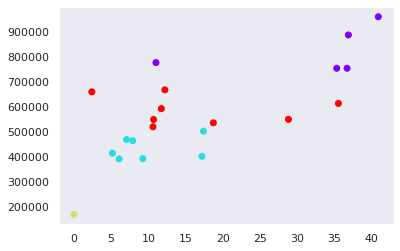

In [31]:
plt.scatter(genre_summary_flat['revenue_world_adj_mean'],genre_summary_flat['rating_count_mean'],c=genre_summary_flat['clusters'],cmap='rainbow')

In [32]:
genre_summary_flat[['genre','clusters']].sort_values(by='clusters')

,genre,clusters
0,Action,0
1,Adventure,0
16,Sci-Fi,0
5,Crime,0
8,Fantasy,0
17,Sport,1
15,Romance,1
13,Musical,1
19,War,1
10,History,1


In [33]:
movie_genre['cluster'] = movie_genre.merge(genre_summary_flat[['genre','clusters']], how='left', on='genre')['clusters']

In [34]:
movie_genre.groupby('cluster').agg({'rating_count':'mean', 'revenue_world_adj':'sum'})

,rating_count,revenue_world_adj
cluster,,
0,812281.472477,6611.404509
1,443210.260274,1430.814403
2,169019.750000,0.013345
3,590660.939058,5068.082029


In [35]:
movie_genre['cluster_label'] = movie_genre['cluster'].replace(
    {
        0: 4,
        3: 3,
        1: 2,
        2: 1
    }
)

In [36]:
movie_cluster = movie_genre.groupby('movie_id').agg({'cluster_label':['max','min']})
movie_cluster.columns = movie_cluster.columns.map('_'.join)
movie_cluster.reset_index(inplace=True)

In [37]:
movies[['cluster_max','cluster_min']] = movies.merge(movie_cluster, how='left', on='movie_id')[['cluster_label_max','cluster_label_min']]

In [38]:
movies.groupby(['cluster_max','cluster_min']).agg({
    'rating':['median','mean'],
    'rating_count':['median','mean'],
    'critic_review_count':['median','mean'],
    'revenue_world_adj':['median','mean'],
    'roi_world':['median','mean'],
})

rating           rating_count                \
                        median      mean       median          mean   
cluster_max cluster_min                                               
2           2             8.25  8.250000     287245.0  3.206424e+05   
3           1             8.10  8.200000     169348.0  1.739613e+05   
            2             8.25  8.296429     321722.5  4.517375e+05   
            3             8.30  8.304545     401045.5  5.863058e+05   
4           1             8.30  8.300000     154195.0  1.541950e+05   
            2             8.20  8.234694     476243.0  5.364490e+05   
            3             8.30  8.365789     729861.5  7.898803e+05   
            4             8.40  8.384615    1011382.0  1.016257e+06   

                        critic_review_count             revenue_world_adj  \
                                     median        mean            median   
cluster_max cluster_min                                                     
2           2                         135.0  140.625000          0.104530   
3           1                         207.0  204.666667          0.002561   
            2                         154.5  202.071429          1.864602   
            3                         195.0  237.681818          1.825915   
4           1                         157.0  157.000000          0.000088   
            2                         168.0  245.102041         11.123991   
            3                         213.0  258.500000          4.159909   
            4                         244.0  275.461538         20.818216   

                                   roi_world             
                              mean    median       mean  
cluster_max cluster_min                                  
2           2             1.690669  4.238623   8.122179  
3           1             0.004419 -0.886306  -0.886306  
            2             6.736256  3.458030  10.201842  
            3             5.744949  3.870989  10.628665  
4           1             0.000088 -0.984697  -0.984697  
            2            19.466601  3.604178   6.420585  
            3            19.961109  3.780023   6.533993  
            4            43.279388  8.878579  15.122367

In [39]:
movies['cluster_pair'] = movies['cluster_max'].astype(str) + "_" + movies['cluster_min'].astype(str)

<AxesSubplot:xlabel='cluster_pair', ylabel='count'>

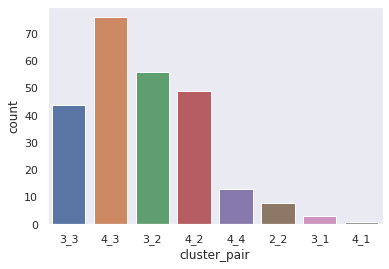

In [40]:
sns.countplot(x=movies['cluster_pair'])

<AxesSubplot:xlabel='cluster_pair', ylabel='count'>

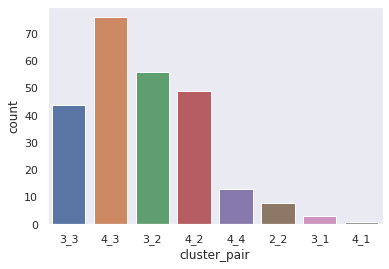

In [41]:
sns.countplot(x=movies['cluster_pair'])